# Movie Recommendation System

In this notebook i will try to implement recommendation algorithm (content based filtering) and i will aslo attempt at giving some insights about the data. With us we have TMDb movie dataset :
    This data set contains information
    about 10,000 movies collected from
    The Movie Database (TMDb),
    including user ratings and revenue.
    
   
    ● The dataset contains full credits 
    for both the cast and the crew,
    rather than just the first three actors.
    
    ●Actor and actresses are now listed in
    the order they appear in the credits.
    
    ●The final two columns ending with “_adj”
    show the budget and revenue of the 
    associated movie in terms of 2010 dollars
    , accounting for inflation over time.
    
    ● The revenues appear to be more current.
    For example, IMDB's figures for Avatar 
    seem to be from 2010 and understate the 
    film's global revenues by over $2 billion.
    
    


In [205]:
#important libraries
import pandas as pd
import numpy as np
import re
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import OrdinalEncoder
import matplotlib.pyplot as plt

In [206]:
df = pd.read_csv("tmdb-movies1.csv")
df.head(3)

,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,...,overview,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj
0,135397,tt0369610,32.985763,150000000,1513528810,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,http://www.jurassicworld.com/,Colin Trevorrow,The park is open.,...,Twenty-two years after the events of Jurassic ...,124,Action|Adventure|Science Fiction|Thriller,Universal Studios|Amblin Entertainment|Legenda...,06 09 15,5562,6.5,2015,137999939.3,1.392446e+09
1,76341,tt1392190,28.419936,150000000,378436354,Mad Max: Fury Road,Tom Hardy|Charlize Theron|Hugh Keays-Byrne|Nic...,http://www.madmaxmovie.com/,George Miller,What a Lovely Day.,...,An apocalyptic story set in the furthest reach...,120,Action|Adventure|Science Fiction|Thriller,Village Roadshow Pictures|Kennedy Miller Produ...,5/13/15,6185,7.1,2015,137999939.3,3.481613e+08
2,262500,tt2908446,13.112507,110000000,295238201,Insurgent,Shailene Woodley|Theo James|Kate Winslet|Ansel...,http://www.thedivergentseries.movie/#insurgent,Robert Schwentke,One Choice Can Destroy You,...,Beatrice Prior must confront her inner demons ...,119,Adventure|Science Fiction|Thriller,Summit Entertainment|Mandeville Films|Red Wago...,3/18/15,2480,6.3,2015,101199955.5,2.716190e+08


In [207]:
df.shape

(10866, 21)

The number of moviess we have is 10866 movies with 21 feature columns we want to invistigate wether these columns is helpful for the recommendation preocess or not.

Also there is some columns that do not need invistigation which will not be useful for the process.

These columns are id,imdb_id,homepage,tagline and overview.

In [208]:
df.dtypes

id                        int64
imdb_id                  object
popularity              float64
budget                    int64
revenue                   int64
original_title           object
cast                     object
homepage                 object
director                 object
tagline                  object
keywords                 object
overview                 object
runtime                   int64
genres                   object
production_companies     object
release_date             object
vote_count                int64
vote_average            float64
release_year              int64
budget_adj              float64
revenue_adj             float64
dtype: object

In [209]:
columns_drop = ["id","imdb_id","homepage","tagline","overview"]
df.drop(columns_drop,axis=1,inplace=True)
df.shape

(10866, 16)

In [210]:
#create a net profit column from budget_adj,revenue_adj columns
df["net_profit"] = df["budget_adj"] - df["revenue_adj"]
df.drop(columns = ["budget_adj","revenue_adj","budget","revenue"]
        ,axis=1,inplace = True)

In [211]:
df.head(1)

,popularity,original_title,cast,director,keywords,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,net_profit
0,32.985763,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,Colin Trevorrow,monster|dna|tyrannosaurus rex|velociraptor|island,124,Action|Adventure|Science Fiction|Thriller,Universal Studios|Amblin Entertainment|Legenda...,06 09 15,5562,6.5,2015,-1.254446e+09


In [212]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10866 entries, 0 to 10865
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   popularity            10866 non-null  float64
 1   original_title        10866 non-null  object 
 2   cast                  10790 non-null  object 
 3   director              10822 non-null  object 
 4   keywords              9373 non-null   object 
 5   runtime               10866 non-null  int64  
 6   genres                10843 non-null  object 
 7   production_companies  9836 non-null   object 
 8   release_date          10866 non-null  object 
 9   vote_count            10866 non-null  int64  
 10  vote_average          10866 non-null  float64
 11  release_year          10866 non-null  int64  
 12  net_profit            10866 non-null  float64
dtypes: float64(3), int64(3), object(7)
memory usage: 1.1+ MB


From this we that some columns have null values like cast, director and 
production_companies.
but i will not drop the null alues them untill i see if the columns have
useful information or not

In [213]:
df.describe()

,popularity,runtime,vote_count,vote_average,release_year,net_profit
count,10866.000000,10866.000000,10866.000000,10866.000000,10866.000000,1.086600e+04
mean,0.646441,102.070863,217.389748,5.974922,2001.322658,-3.381332e+07
std,1.000185,31.381405,575.619058,0.935142,12.812941,1.252151e+08
min,0.000065,0.000000,10.000000,1.500000,1960.000000,-2.750137e+09
25%,0.207583,90.000000,17.000000,5.400000,1995.000000,-1.292617e+07
50%,0.383856,99.000000,38.000000,6.000000,2006.000000,0.000000e+00
75%,0.713817,111.000000,145.750000,6.600000,2011.000000,0.000000e+00
max,32.985763,900.000000,9767.000000,9.200000,2015.000000,4.139124e+08


From this table we can observe to outliers we want to invistigate about :
 - the first in runtime column which have a vlaue of 900 minutes
 - vote_count over 9767 
 
The best way to ivistigate them by plotting histograms.

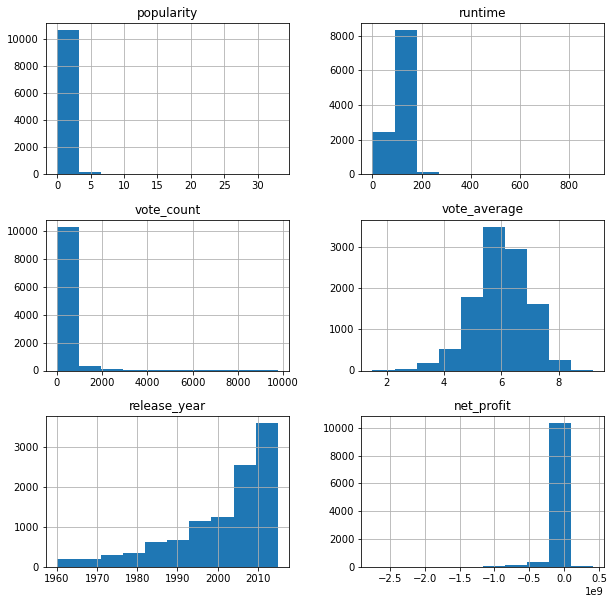

In [214]:
df.hist(figsize=(10,10));

In [215]:
#check for duolicates
df.duplicated().sum()

1

In [216]:
df[df.duplicated(keep=False)]

,popularity,original_title,cast,director,keywords,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,net_profit
2089,0.59643,TEKKEN,Jon Foo|Kelly Overton|Cary-Hiroyuki Tagawa|Ian...,Dwight H. Little,martial arts|dystopia|based on video game|mart...,92,Crime|Drama|Action|Thriller|Science Fiction,Namco|Light Song Films,3/20/10,110,5.0,2010,29033000.0
2090,0.59643,TEKKEN,Jon Foo|Kelly Overton|Cary-Hiroyuki Tagawa|Ian...,Dwight H. Little,martial arts|dystopia|based on video game|mart...,92,Crime|Drama|Action|Thriller|Science Fiction,Namco|Light Song Films,3/20/10,110,5.0,2010,29033000.0


it is a duplicated value not a similar name or something like that so we drop it

In [217]:
df.drop_duplicates(inplace=True)

Remove every special characters in the original_title in the movie to facilitate input the data

In [218]:
df["original_title"] = df["original_title"].apply(
    lambda x : re.sub('[^a-zA-Z.\d\s]', '', x))
df.head(5)

,popularity,original_title,cast,director,keywords,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,net_profit
0,32.985763,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,Colin Trevorrow,monster|dna|tyrannosaurus rex|velociraptor|island,124,Action|Adventure|Science Fiction|Thriller,Universal Studios|Amblin Entertainment|Legenda...,06 09 15,5562,6.5,2015,-1.254446e+09
1,28.419936,Mad Max Fury Road,Tom Hardy|Charlize Theron|Hugh Keays-Byrne|Nic...,George Miller,future|chase|post-apocalyptic|dystopia|australia,120,Action|Adventure|Science Fiction|Thriller,Village Roadshow Pictures|Kennedy Miller Produ...,5/13/15,6185,7.1,2015,-2.101614e+08
2,13.112507,Insurgent,Shailene Woodley|Theo James|Kate Winslet|Ansel...,Robert Schwentke,based on novel|revolution|dystopia|sequel|dyst...,119,Adventure|Science Fiction|Thriller,Summit Entertainment|Mandeville Films|Red Wago...,3/18/15,2480,6.3,2015,-1.704191e+08
3,11.173104,Star Wars The Force Awakens,Harrison Ford|Mark Hamill|Carrie Fisher|Adam D...,J.J. Abrams,android|spaceship|jedi|space opera|3d,136,Action|Adventure|Science Fiction|Fantasy,Lucasfilm|Truenorth Productions|Bad Robot,12/15/15,5292,7.5,2015,-1.718723e+09
4,9.335014,Furious 7,Vin Diesel|Paul Walker|Jason Statham|Michelle ...,James Wan,car race|speed|revenge|suspense|car,137,Action|Crime|Thriller,Universal Pictures|Original Film|Media Rights ...,04 01 15,2947,7.3,2015,-1.210949e+09


Cleaning columns that contain "|" in their records like in cast , genres and production_companies

In [219]:
cols = ["cast","genres", "production_companies","keywords"]
'''create a function to check if the given redord have a null value or not
   as split function dose not work with null value and i do not want to 
   movies with null values in thier columns '''
def dele(x):
    if isinstance(x, str) :
        return x.split("|")
    else : pass  
        
for c in cols:
    df[c] = df[c].apply(lambda x : dele(x))
df.head(1)

,popularity,original_title,cast,director,keywords,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,net_profit
0,32.985763,Jurassic World,"[Chris Pratt, Bryce Dallas Howard, Irrfan Khan...",Colin Trevorrow,"[monster, dna, tyrannosaurus rex, velociraptor...",124,"[Action, Adventure, Science Fiction, Thriller]","[Universal Studios, Amblin Entertainment, Lege...",06 09 15,5562,6.5,2015,-1.254446e+09


create a copy dataframe to invistigate which is the most popular column

In [220]:
df_c = df.copy()
df_c = df_c.explode("genres")
df.head(1)

,popularity,original_title,cast,director,keywords,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,net_profit
0,32.985763,Jurassic World,"[Chris Pratt, Bryce Dallas Howard, Irrfan Khan...",Colin Trevorrow,"[monster, dna, tyrannosaurus rex, velociraptor...",124,"[Action, Adventure, Science Fiction, Thriller]","[Universal Studios, Amblin Entertainment, Lege...",06 09 15,5562,6.5,2015,-1.254446e+09


Here we see gennres column is exploded and movie column has repeated records where each movie has multiple values for genres

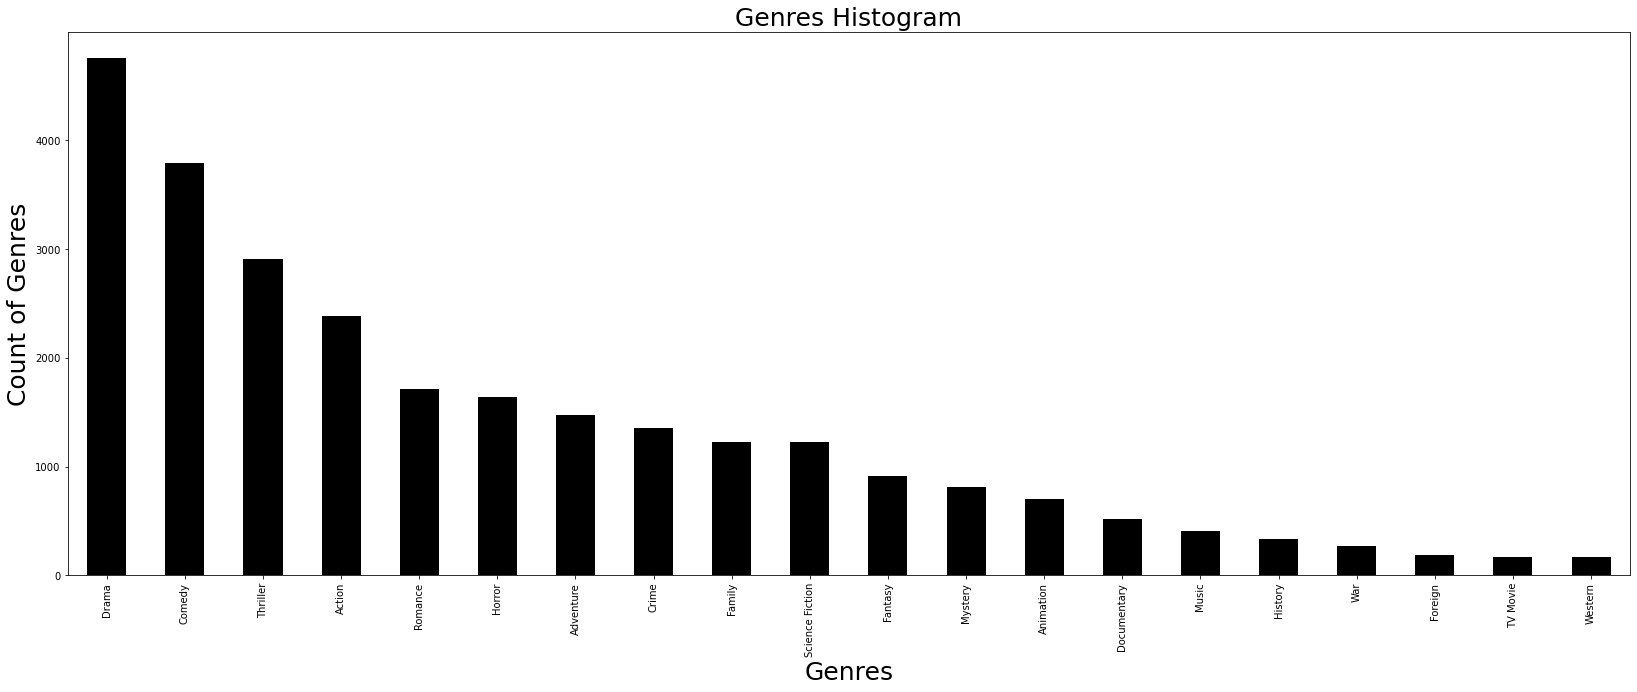

In [221]:
df_c["genres"].value_counts().plot(kind="bar",figsize=(28,10),color="black");
plt.xlabel("Genres",fontsize =25);
plt.ylabel("Count of Genres",fontsize =25)
plt.title("Genres Histogram",fontsize =25);

Drama is most commom genre where Western is the lowest




Now,transform Genres column into coded values of one for fitting the algorithm and invistigating

In [222]:
#first fill null values of a string to avoid null values error
df.fillna("s",inplace = True)

In [223]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer(sparse_output=True)
cols2 = ["genres"]
for i in cols2: 
    df = df.join(
                pd.DataFrame.sparse.from_spmatrix(
                    mlb.fit_transform(df.pop(i)),
                    index=df.index,
                    columns=mlb.classes_))

In [224]:
#then drop te empty string column
df.drop("s",axis=1,inplace = True)
df.head(1)

,popularity,original_title,cast,director,keywords,runtime,production_companies,release_date,vote_count,vote_average,...,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
0,32.985763,Jurassic World,"[Chris Pratt, Bryce Dallas Howard, Irrfan Khan...",Colin Trevorrow,"[monster, dna, tyrannosaurus rex, velociraptor...",124,"[Universal Studios, Amblin Entertainment, Lege...",06 09 15,5562,6.5,...,0,0,0,0,0,1,0,1,0,0


Apply ordinal encoder to directors column, to transform it to numerical values

In [225]:
df["director"].fillna("s",inplace = True)
encoder = OrdinalEncoder()
df["director"] = encoder.fit_transform(np.array(df["director"]).reshape(-1,1))
df.head(1)

,popularity,original_title,cast,director,keywords,runtime,production_companies,release_date,vote_count,vote_average,...,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
0,32.985763,Jurassic World,"[Chris Pratt, Bryce Dallas Howard, Irrfan Khan...",899.0,"[monster, dna, tyrannosaurus rex, velociraptor...",124,"[Universal Studios, Amblin Entertainment, Lege...",06 09 15,5562,6.5,...,0,0,0,0,0,1,0,1,0,0


To personalise our recommendations more, I am going to build an engine that computes similarity between movies based on cast, keywords and production compamnies 

for instance, if someone liked Iron man movie, he may be interested in marvel movies.

The same for keywords, if someone liked a movies with spy and undercover keywords in it, he may be interested in all sp movies.

In [248]:
''' Buid a function that takes a column as a given input which contains a list as record value
    and then takes the top 3 values in it and transform it to 3 columns and then
    concatenate it with original dataframe'''
def split_concate(subject):
    df[subject] = df[subject].apply(lambda x : x[:3])
    df_copy = pd.DataFrame(df[subject].to_list(),columns = [subject+"1",subject+"2",subject+"3"])
    return result

In [268]:
#Then apply the transformation
df_1 = split_dataframe("cast")
df_2 = split_dataframe("keywords")
df_3 = split_dataframe("production_companies")
frame = [df,df_1,df_2,df_3]
result = pd.concat(frame,axis=1)
df = result.loc[:,~result.columns.duplicated()].copy() #drop duplicated columns

In [269]:
df.head(2)

,popularity,original_title,cast,director,keywords,runtime,production_companies,release_date,vote_count,vote_average,...,Western,cast1,cast2,cast3,keywords1,keywords2,keywords3,production_companies1,production_companies2,production_companies3
0,32.985763,Jurassic World,"[Chris Pratt, Bryce Dallas Howard, Irrfan Khan]",899.0,"[monster, dna, tyrannosaurus rex]",124.0,"[Universal Studios, Amblin Entertainment, Lege...",06 09 15,5562.0,6.5,...,0.0,Chris Pratt,Bryce Dallas Howard,Irrfan Khan,monster,dna,tyrannosaurus rex,Universal Studios,Amblin Entertainment,Legendary Pictures
1,28.419936,Mad Max Fury Road,"[Tom Hardy, Charlize Theron, Hugh Keays-Byrne]",1681.0,"[future, chase, post-apocalyptic]",120.0,"[Village Roadshow Pictures, Kennedy Miller Pro...",5/13/15,6185.0,7.1,...,0.0,Tom Hardy,Charlize Theron,Hugh Keays-Byrne,future,chase,post-apocalyptic,Village Roadshow Pictures,Kennedy Miller Productions,None


In [295]:
#drop duplicated columns
columns_drop = ["cast","keywords","production_companies","release_date"]
df.drop(columns_drop,axis=1,inplace=True)

In [296]:
df.head()

,popularity,original_title,director,runtime,vote_count,vote_average,release_year,net_profit,Action,Adventure,...,Western,cast1,cast2,cast3,keywords1,keywords2,keywords3,production_companies1,production_companies2,production_companies3
0,32.985763,Jurassic World,899.0,124.0,5562.0,6.5,2015.0,-1.254446e+09,1.0,1.0,...,0.0,Chris Pratt,Bryce Dallas Howard,Irrfan Khan,monster,dna,tyrannosaurus rex,Universal Studios,Amblin Entertainment,Legendary Pictures
1,28.419936,Mad Max Fury Road,1681.0,120.0,6185.0,7.1,2015.0,-2.101614e+08,1.0,1.0,...,0.0,Tom Hardy,Charlize Theron,Hugh Keays-Byrne,future,chase,post-apocalyptic,Village Roadshow Pictures,Kennedy Miller Productions,None
2,13.112507,Insurgent,4130.0,119.0,2480.0,6.3,2015.0,-1.704191e+08,0.0,1.0,...,0.0,Shailene Woodley,Theo James,Kate Winslet,based on novel,revolution,dystopia,Summit Entertainment,Mandeville Films,Red Wagon Entertainment
3,11.173104,Star Wars The Force Awakens,1942.0,136.0,5292.0,7.5,2015.0,-1.718723e+09,1.0,1.0,...,0.0,Harrison Ford,Mark Hamill,Carrie Fisher,android,spaceship,jedi,Lucasfilm,Truenorth Productions,Bad Robot
4,9.335014,Furious 7,2058.0,137.0,2947.0,7.3,2015.0,-1.210949e+09,1.0,0.0,...,0.0,Vin Diesel,Paul Walker,Jason Statham,car race,speed,revenge,Universal Pictures,Original Film,Media Rights Capital


In [ ]:
df["director"].fillna("s",inplace = True)
encoder = OrdinalEncoder()
df["director"] = encoder.fit_transform(np.array(df["director"]).reshape(-1,1))
df.head(1)

In [322]:
#apply ordinal encoder for cast,keywords and production_companies colunmns
cols = ["cast1","keywords1","production_companies1","cast2","keywords2","production_companies2"
       ,"cast3","keywords3","production_companies3"]
df.fillna("s",inplace = True)
for c in cols:
    df[c] = encoder.fit_transform(np.array(df[c]).reshape(-1,1))
df.head(1)

,popularity,original_title,director,runtime,vote_count,vote_average,release_year,net_profit,Action,Adventure,...,Western,cast1,cast2,cast3,keywords1,keywords2,keywords3,production_companies1,production_companies2,production_companies3
0,32.985763,Jurassic World,899.0,124.0,5562.0,6.5,2015.0,-1254445953.7,1.0,1.0,...,0.0,746.0,727.0,2469.0,1347.0,777.0,3221.0,2844.0,146.0,1299.0
